In [1]:
import os
import json
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 
import nrrd

import os
from lungmask import LMInferer
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import nibabel as nib
from utils.preprocessing import hu_data, convert_signed_4bit_to_hu, convert_to_signed_4bit, remove_gantry
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border

from utils.vis import plot_images_nib, plot_images, analyze_inhale_exhale, plot_slice
from utils.preprocessing import hu_data, remove_gantry, apply_clahe, convert_signed_4bit_to_hu, convert_to_signed_4bit, fill_chest_cavity, convert_signed_4bit_to_unsigned_8bit, segment_kmeans
from utils.segment import apply_lungmask_binary, apply_lungmask_thresholded


In [2]:
DATA_PATH = './data'
RESULT_PATH = './results'
PARAMETER_PATH = './parameter'
ELASTIX_PATH = './elastix'
DATA_PATH_4BIT = './data_4bit'
MASK_PATH = './mask'
dataset_info = json.load(open("./data/dataset_info.json"))
save = False
vis = False

# Image Check

In [152]:
key = 'copd4'
inhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz'))
exhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz'))
inhale_data = inhale_image.get_fdata()
exhale_data = exhale_image.get_fdata()

In [4]:
if vis == True:
    plot_images_nib([inhale_image, exhale_image], titles=[f"{key} Inhale", f"{key} Exhale"], cols=2, slice_idx=50, fig_size=(10, 10))

In [5]:
if vis == True:
    analyze_inhale_exhale(inhale_data, exhale_data)

In [6]:
hu_inhale = hu_data(inhale_data)
hu_exhale = hu_data(exhale_data)

In [7]:
if vis == True:
    analyze_inhale_exhale(hu_inhale, hu_exhale)

In [8]:
if save == True:
    inhale_save = os.path.join(DATA_PATH, key, f'{key}_iBHCT_hu.nii.gz')
    exhale_save = os.path.join(DATA_PATH, key, f'{key}_eBHCT_hu.nii.gz')

    inhale_image_hu = nib.Nifti1Image(hu_inhale, inhale_image.affine)
    exhale_image_hu = nib.Nifti1Image(hu_exhale, exhale_image.affine)
    nib.save(inhale_image_hu, inhale_save)
    nib.save(exhale_image_hu, exhale_save)

In [20]:
def enhance_ct_contrast_invert_lungs(ct_image, window_level=-500, window_width=1500):
    """
    Enhances the contrast of a 3D CT image to make lung regions darker.

    Parameters:
        ct_image (numpy.ndarray): 3D CT image (HxWxD) in Hounsfield Units (HU).
        window_level (int): Center of the window (default: -500 for lungs).
        window_width (int): Width of the window (default: 1500 for lungs).

    Returns:
        numpy.ndarray: Contrast-enhanced 3D CT image with lungs darker.
    """
    enhanced_volume = np.zeros_like(ct_image, dtype=np.uint8)

    # Calculate window limits
    min_window = window_level - window_width // 2
    max_window = window_level + window_width // 2

    # Process each slice
    for z in range(ct_image.shape[2]):
        slice_image = ct_image[:, :, z]

        # Apply windowing and invert the intensities
        slice_windowed = np.clip(slice_image, min_window, max_window)
        slice_normalized = (slice_windowed - min_window) / (max_window - min_window)  # Normalize to [0, 1]
        slice_inverted = 1 - slice_normalized  # Invert intensities
        slice_scaled = (slice_inverted * 255).astype(np.uint8)  # Scale to [0, 255]

        enhanced_volume[:, :, z] = slice_scaled

    return enhanced_volume


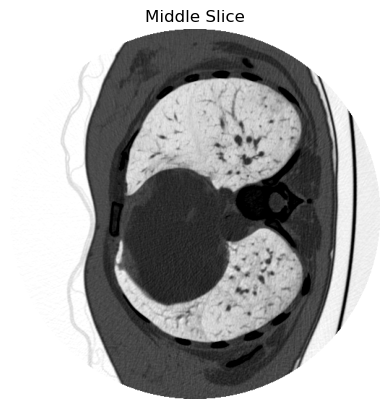

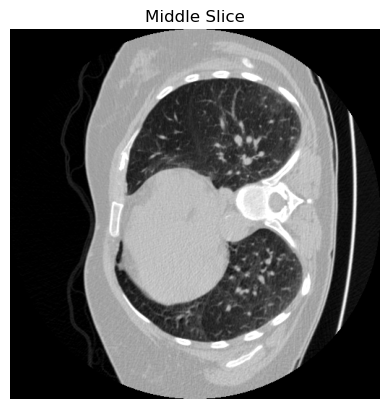

In [21]:
enhanced = enhance_ct_contrast_invert_lungs(hu_inhale)
plot_slice(enhanced)
plot_slice(hu_inhale)

In [9]:
bit_4 = convert_to_signed_4bit(hu_exhale)
bit_4_hu = convert_signed_4bit_to_hu(bit_4)
exhale_8 = convert_signed_4bit_to_unsigned_8bit(bit_4)

In [ ]:
def apply_lungmask_thresholded(image, output_path=None, vis=False):
    """
    Applies the LungMask model (default U-Net R231) to segment lungs from a 3D CT image
    and converts the output into a binary mask (1: Lung, 0: Background).

    Parameters:
        image_path (str): Path to the 3D CT image file (e.g., .nii or .nii.gz).
        output_path (str, optional): Path to save the binary lung mask. If None, the mask is not saved.
        plot (bool): Whether to plot the original image and the binary lung mask (default: False).

    Returns:
        numpy.ndarray: Binary lung mask (3D array) with:
                       - 1: Lung (left or right)
                       - 0: Background
    """

    if isinstance(image, str):
        image = nib.load(image).get_fdata()  # Read image if it's a file path

    hu_image = hu_data(image) 
    bit_4 = convert_to_signed_4bit(hu_image)
    bit_4_hu = convert_signed_4bit_to_hu(bit_4)

    _, thresholded = cv.threshold(bit_4_hu, -400, 1, cv.THRESH_BINARY_INV)

    borderless = np.zeros_like(thresholded, dtype=np.uint8)
    for z in range(thresholded.shape[2]):
        borderless[:, :, z] = clear_border(thresholded[:,:,z])
        borderless[:, :, z] = cv.morphologyEx(borderless[:, :, z], cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11)))
        borderless[:, :, z] = cv.morphologyEx(borderless[:, :, z], cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11)))
        borderless[:, :, z] = binary_fill_holes(borderless[:, :, z])
    
    for y in range(thresholded.shape[1]):
        borderless[:, y, :] = cv.morphologyEx(borderless[:, y, :], cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7)))
        borderless[:, y, :] = binary_fill_holes(borderless[:, y, :])

    lung_mask = borderless
    # Save the binary lung mask if an output path is specified
    if output_path:
        # Create a NIfTI image using the lung mask and the original image's affine and header
        lung_mask_image = nib.Nifti1Image(lung_mask, affine=image.affine, header=image.header)
        
        # Save the NIfTI image
        nib.save(lung_mask_image, output_path)

    # Plot if requested
    if vis:
        slice_index = image.shape[2] // 2  # Middle slice
        plt.figure(figsize=(12, 6))
        
        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(image[:, :, slice_index], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # Binary Lung Mask
        plt.subplot(1, 2, 2)
        plt.imshow(lung_mask[:, :, slice_index], cmap='gray')
        plt.title('Binary Lung Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    return lung_mask

In [6]:
lung = apply_lungmask_thresholded(inhale_data)

In [11]:
for y in range(lung.shape[1]):
    lung[:, y, :] = cv.morphologyEx(lung[:, y, :], cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7)))
    lung[:, y, :] = binary_fill_holes(lung[:, y, :])

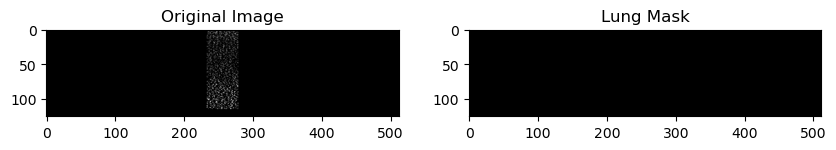

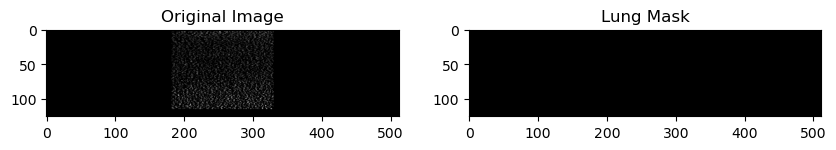

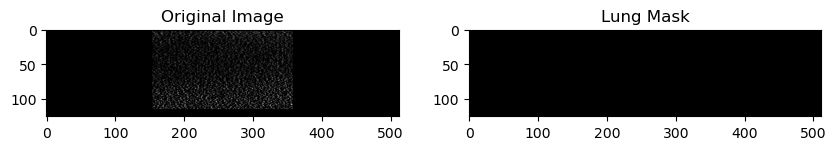

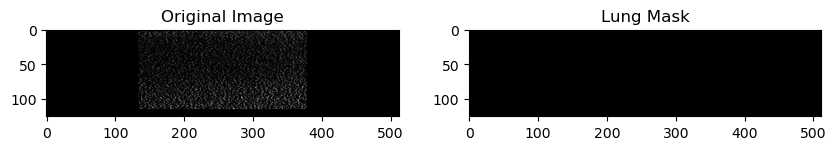

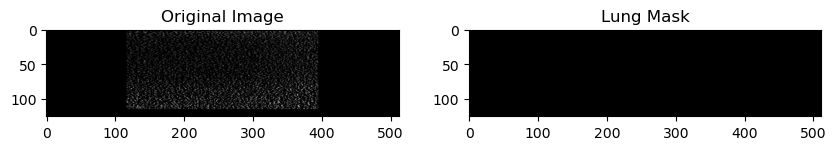

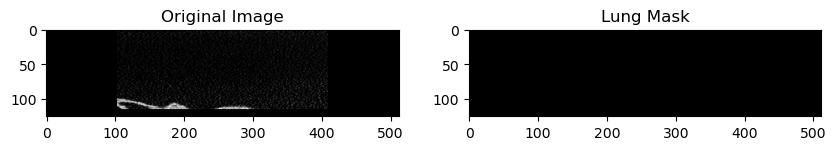

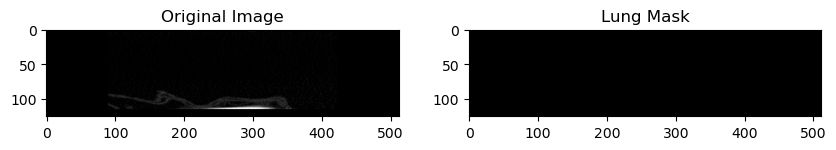

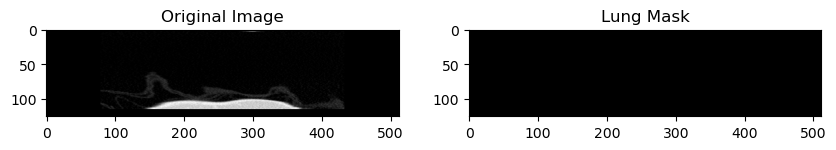

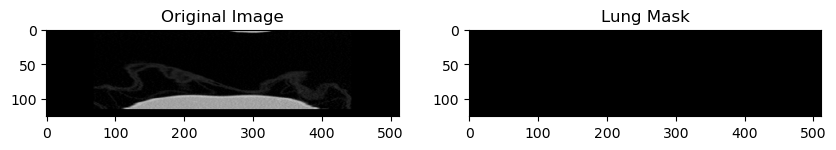

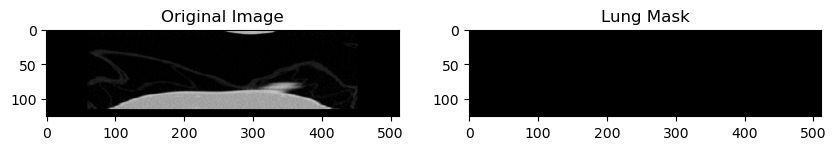

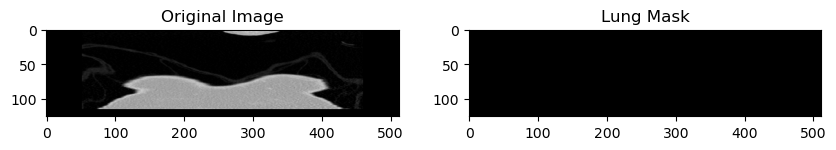

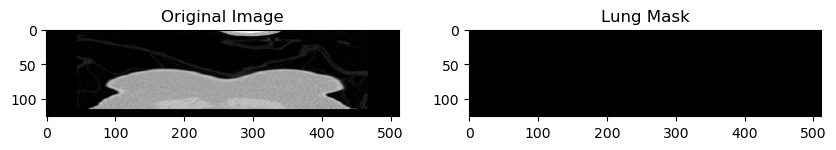

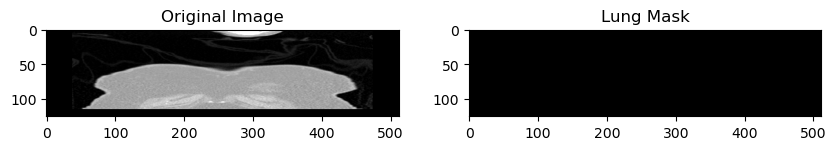

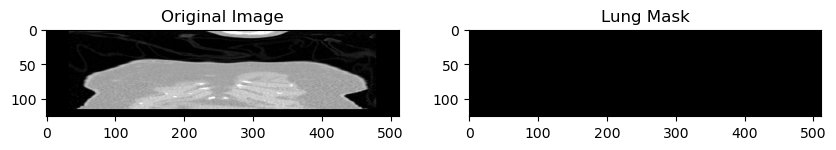

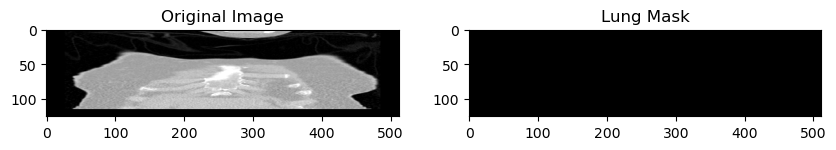

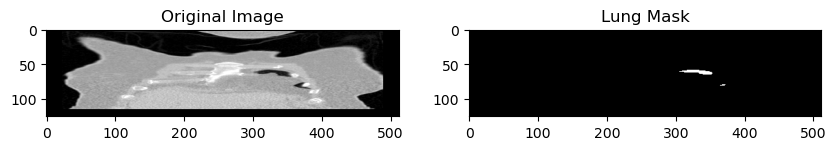

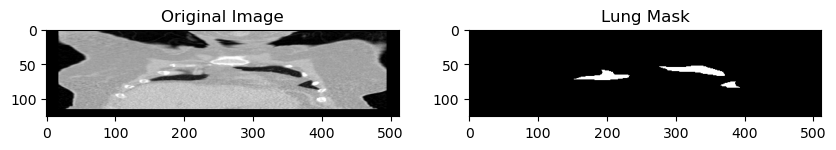

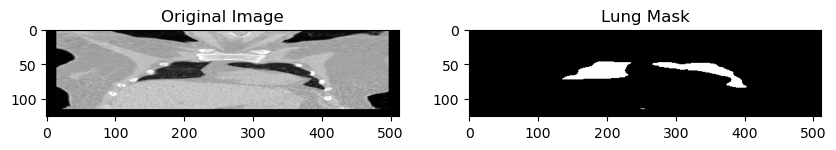

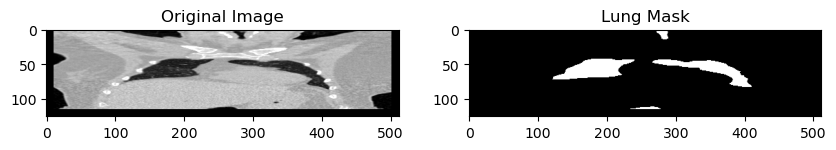

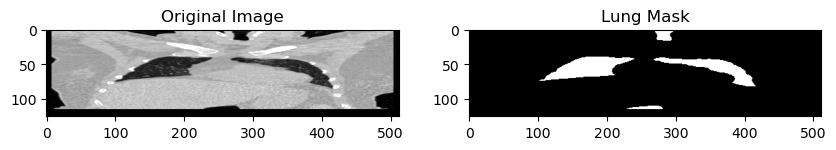

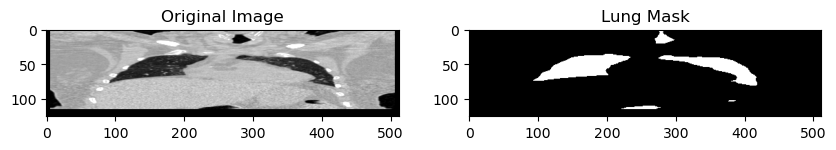

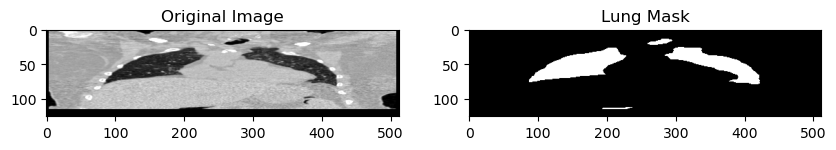

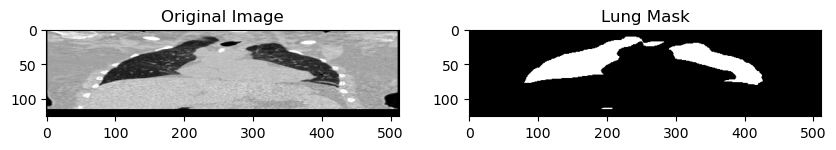

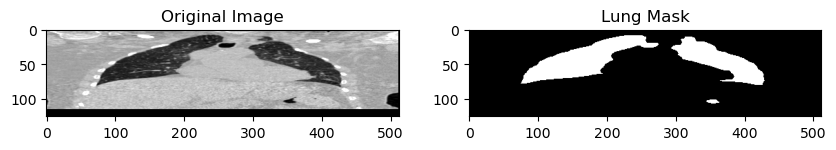

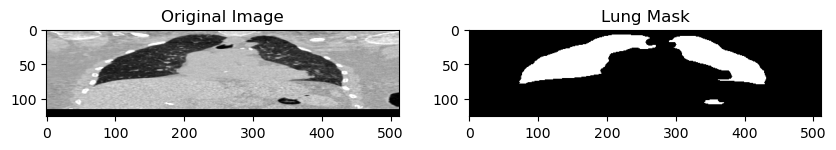

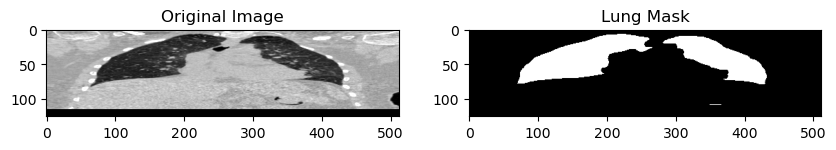

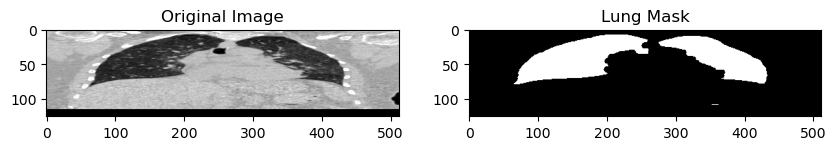

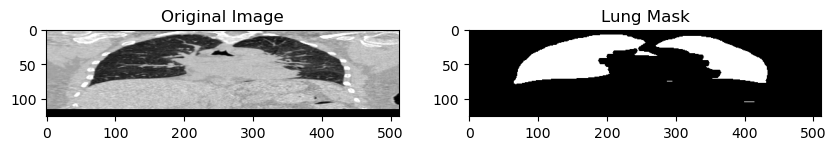

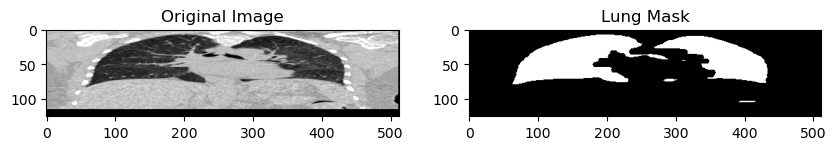

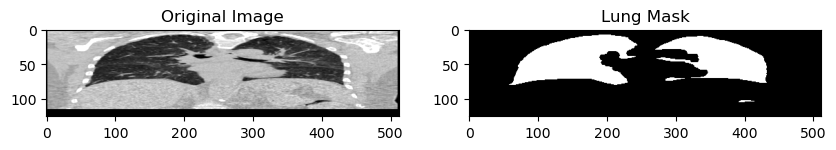

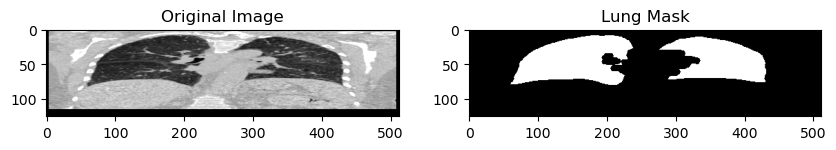

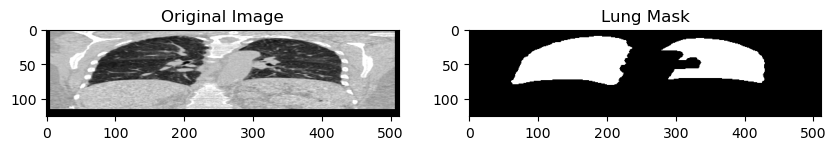

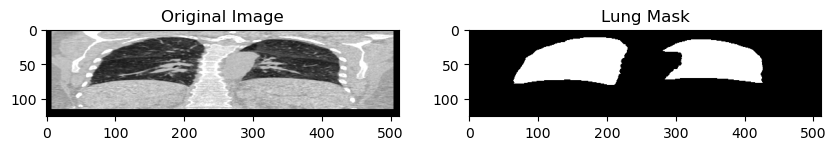

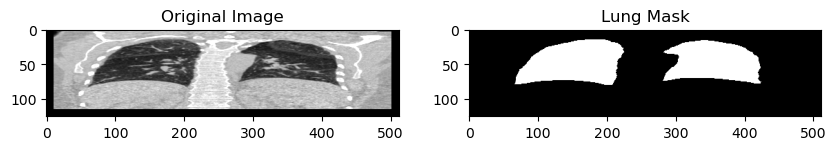

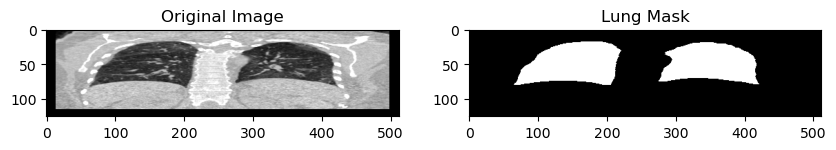

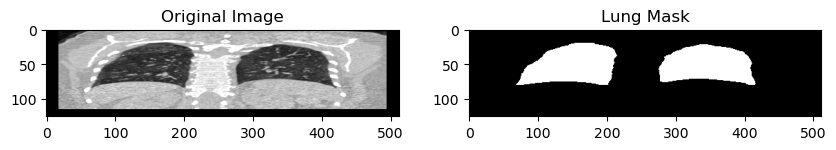

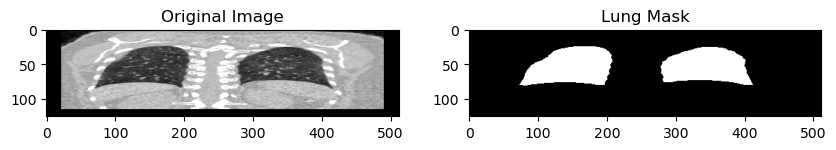

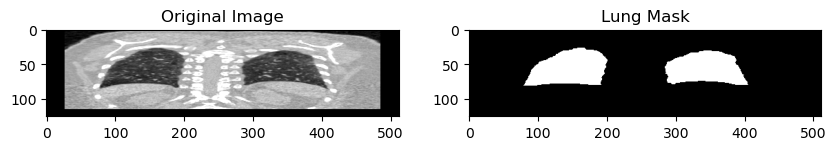

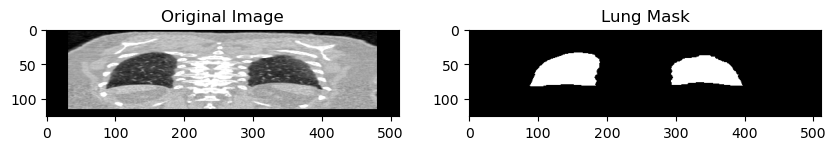

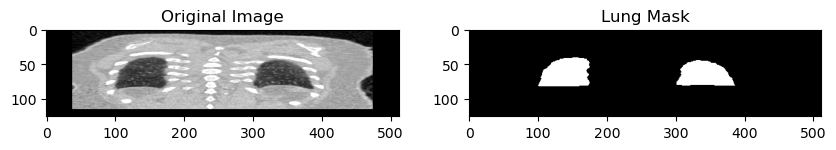

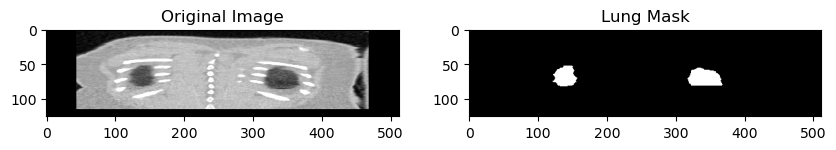

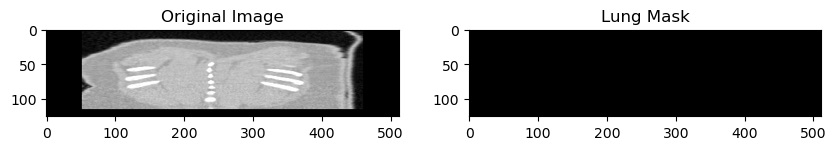

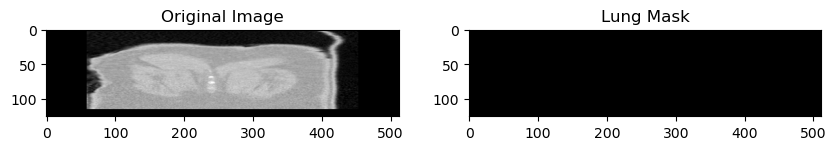

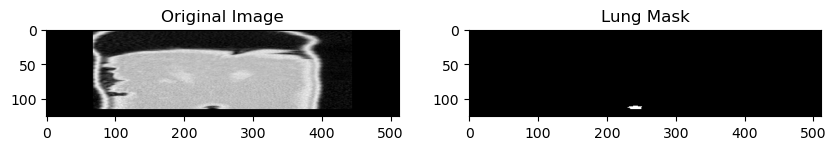

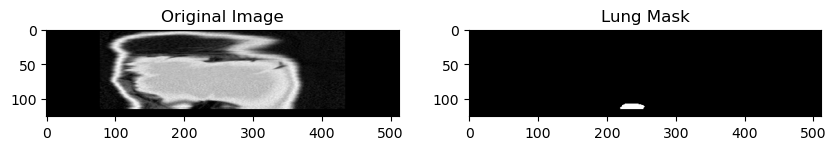

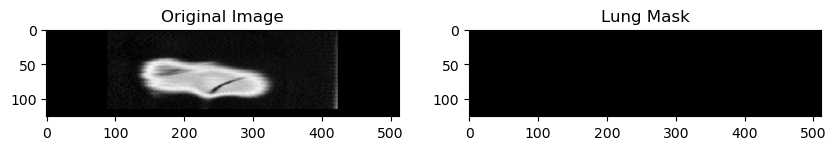

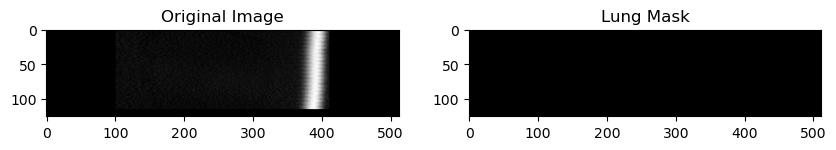

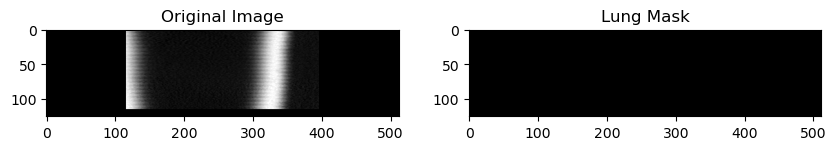

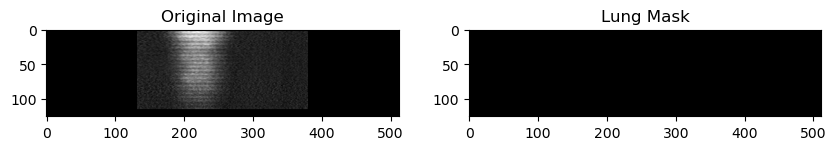

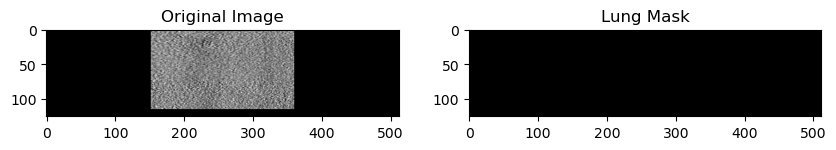

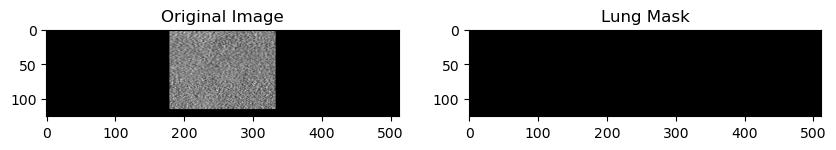

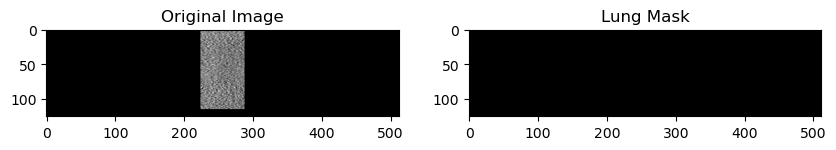

In [12]:
for i in range(0, hu_inhale.shape[0], 10):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(np.transpose(hu_inhale[:, i, :]), cmap="gray")
    ax[0].set_title("Original Image")
    ax[1].imshow(np.transpose(lung[:, i, :]), cmap="gray")
    ax[1].set_title("Lung Mask")
    plt.show()

In [17]:
seg = apply_lungmask_binary(exhale_data)
seg_thresholded = apply_lungmask_thresholded(exhale_data)

lungmask 2025-01-05 01:30:14 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


 98%|█████████▊| 25/25.6 [00:22<00:00,  1.11it/s]/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 26/25.6 [00:23<00:00,  1.11it/s]

lungmask 2025-01-05 01:30:39 Postprocessing



100%|██████████| 60/60 [00:01<00:00, 46.25it/s] 


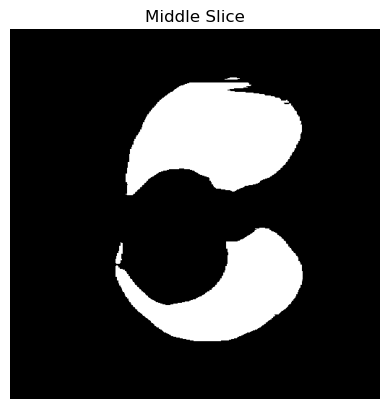

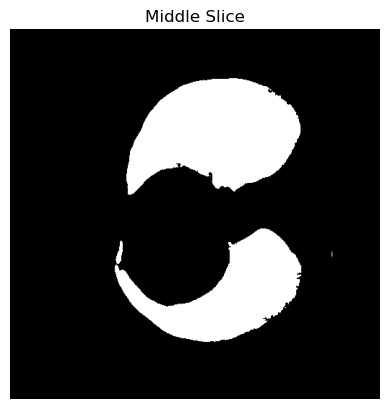

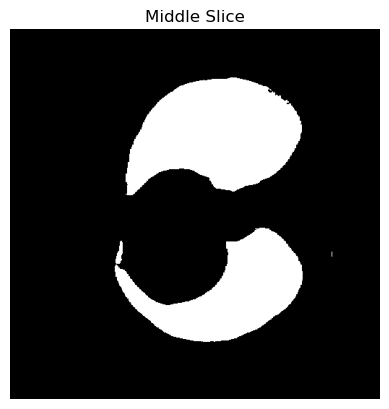

In [22]:
if vis == True:
    plot_slice(seg)
    plot_slice(seg_thresholded)
    plot_slice(np.bitwise_or(seg, seg_thresholded))

In [12]:
if vis == True:
    for i in range(0, 120, 10):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(hu_exhale[:, :, i], cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(np.bitwise_or(seg, seg_thresholded)[:, :, i], cmap="gray")
        ax[1].set_title("Lung Mask")
        plt.show()

# Loop for Images

In [3]:
save = True
if save == True:
    for key, value in dataset_info.items():
        print(f"Processing {key}")
        
        ## Read the images
        inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
        exhale_image_path = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
            
        inhale_image = nib.load(exhale_image_path)
        inhale_data = inhale_image.get_fdata()
        exhale_image = nib.load(exhale_image_path)
        exhale_data = exhale_image.get_fdata()

        ## Preprocess the images
        hu_inhale = hu_data(inhale_data)
        hu_exhale = hu_data(exhale_data)

        inhale_bit_4 = convert_to_signed_4bit(hu_inhale)
        exhale_bit_4 = convert_to_signed_4bit(hu_exhale)

        inhale_bit_4_hu = convert_signed_4bit_to_hu(inhale_bit_4)
        exhale_bit_4_hu = convert_signed_4bit_to_hu(exhale_bit_4)

        lung_inhale = apply_lungmask_binary(inhale_data)
        lung_exhale = apply_lungmask_binary(exhale_data)

        lung_inhale_threholded = apply_lungmask_thresholded(inhale_data)
        lung_exhale_threholded = apply_lungmask_thresholded(exhale_data)

        ## Export hu images
        inhale_export_path = os.path.join(DATA_PATH, key)
        exhale_export_path = os.path.join(DATA_PATH, key)
        os.makedirs(inhale_export_path, exist_ok=True)
        os.makedirs(exhale_export_path, exist_ok=True)
        inhale_hu = nib.Nifti1Image(hu_inhale, inhale_image.affine)
        exhale_hu = nib.Nifti1Image(hu_exhale, exhale_image.affine)
        nib.save(inhale_hu, os.path.join(inhale_export_path, f'{key}_iBHCT_hu.nii.gz'))
        nib.save(exhale_hu, os.path.join(exhale_export_path, f'{key}_eBHCT_hu.nii.gz'))

        ## Export 4-bit hu images
        inhale_4bit_export_path = os.path.join(DATA_PATH_4BIT, key)
        exhale_4bit_export_path = os.path.join(DATA_PATH_4BIT, key)
        os.makedirs(inhale_4bit_export_path, exist_ok=True)
        os.makedirs(exhale_4bit_export_path, exist_ok=True)
        inhale_4bit_hu = nib.Nifti1Image(inhale_bit_4_hu, inhale_image.affine)
        exhale_4bit_hu = nib.Nifti1Image(exhale_bit_4_hu, exhale_image.affine)
        nib.save(inhale_4bit_hu, os.path.join(inhale_4bit_export_path, f'{key}_iBHCT_4bit.nii.gz'))
        nib.save(exhale_4bit_hu, os.path.join(exhale_4bit_export_path, f'{key}_eBHCT_4bit.nii.gz'))

        ## Export the lung masks
        lung_inhale_export_path = os.path.join(MASK_PATH, key)
        lung_exhale_export_path = os.path.join(MASK_PATH, key)
        os.makedirs(lung_inhale_export_path, exist_ok=True)
        os.makedirs(lung_exhale_export_path, exist_ok=True)
        lung_inhale_nib = nib.Nifti1Image(lung_inhale, inhale_image.affine)
        lung_exhale_nib = nib.Nifti1Image(lung_exhale, exhale_image.affine)
        nib.save(lung_inhale_nib, os.path.join(lung_inhale_export_path, f'{key}_iBHCT_lung_mask.nii.gz'))
        print('*'*50, 'lung mask saved', '*'*50)
        nib.save(lung_exhale_nib, os.path.join(lung_exhale_export_path, f'{key}_eBHCT_lung_mask.nii.gz'))
        print('*'*50, 'lung mask saved', '*'*50)

        ## Export the thresholded lung masks
        lung_inhale_thresholded_export_path = os.path.join(MASK_PATH, key)
        lung_exhale_thresholded_export_path = os.path.join(MASK_PATH, key)
        os.makedirs(lung_inhale_thresholded_export_path, exist_ok=True)
        os.makedirs(lung_exhale_thresholded_export_path, exist_ok=True)
        lung_inhale_thresholded_nib = nib.Nifti1Image(lung_inhale_threholded, inhale_image.affine)
        lung_exhale_thresholded_nib = nib.Nifti1Image(lung_exhale_threholded, exhale_image.affine)
        nib.save(lung_inhale_thresholded_nib, os.path.join(lung_inhale_thresholded_export_path, f'{key}_iBHCT_lung_mask_thresholded.nii.gz'))
        print('*'*50, 'lung mask saved', '*'*50)    
        nib.save(lung_exhale_thresholded_nib, os.path.join(lung_exhale_thresholded_export_path, f'{key}_eBHCT_lung_mask_thresholded.nii.gz'))
        print('*'*50, 'lung mask saved', '*'*50)   
        

Processing copd1
lungmask 2025-01-07 05:14:54 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


 98%|█████████▊| 25/25.6 [00:22<00:00,  1.10it/s]/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 26/25.6 [00:23<00:00,  1.10it/s]

lungmask 2025-01-07 05:15:20 Postprocessing



100%|██████████| 104/104 [00:03<00:00, 33.67it/s]


lungmask 2025-01-07 05:15:26 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 05:15:53 Postprocessing



100%|██████████| 104/104 [00:02<00:00, 48.46it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd2
lungmask 2025-01-07 05:16:10 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 05:16:37 Postprocessing



100%|██████████| 149/149 [00:02<00:00, 51.91it/s]


lungmask 2025-01-07 05:16:43 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 05:17:09 Postprocessing



100%|██████████| 149/149 [00:02<00:00, 49.83it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd3
lungmask 2025-01-07 05:17:26 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 05:17:53 Postprocessing



100%|██████████| 123/123 [00:03<00:00, 39.50it/s]


lungmask 2025-01-07 05:17:59 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 05:18:26 Postprocessing



100%|██████████| 123/123 [00:03<00:00, 39.59it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd4
lungmask 2025-01-07 05:18:45 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:24<00:00,  1.08it/s]

lungmask 2025-01-07 05:19:12 Postprocessing



100%|██████████| 60/60 [00:01<00:00, 46.53it/s] 


lungmask 2025-01-07 05:19:17 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:24<00:00,  1.08it/s]

lungmask 2025-01-07 05:19:44 Postprocessing



100%|██████████| 60/60 [00:01<00:00, 46.41it/s] 


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************


In [33]:
def convert_nrrd_to_nii_gz(nrrd_file, reference_nii_file, output_nii_file=None):
    """
    Converts a mask from a .nrrd file to a .nii.gz file using affine information
    from a reference .nii.gz file. Saves the result only if output_nii_file is provided.

    Parameters:
        nrrd_file (str): Path to the input .nrrd file.
        reference_nii_file (str): Path to the reference .nii.gz file.
        output_nii_file (str, optional): Path to save the output .nii.gz file. If None, does not save.

    Returns:
        nib.Nifti1Image: The NIfTI image object created from the .nrrd file.
    """
    # Load the .nrrd file
    mask_data, mask_header = nrrd.read(nrrd_file)

    mask_in_all = mask_data[0,:,:,:]
    mask_in_right = mask_data[1,:,:,:]
    mask_in_left = mask_data[2,:,:,:]
    mask_without_trachea = np.bitwise_and(mask_in_left, mask_in_right)
    mask_with_trachea = np.where(mask_in_all>0, 1, 0).astype(np.uint8)
        
    # Load the reference .nii.gz file
    reference_nii = nib.load(reference_nii_file)
    affine = reference_nii.affine  # Get affine transformation

    # Convert the mask data to a NIfTI image
    mask_with_trachea = nib.Nifti1Image(mask_with_trachea, affine=affine)
    mask_without_trachea = nib.Nifti1Image(mask_without_trachea, affine=affine)

    # Save the NIfTI image if output_nii_file is provided
    if output_nii_file:
        nib.save(mask_with_trachea, os.path.join(output_nii_file, "mask_with_trachea.nii.gz"))
        nib.save(mask_without_trachea, output_nii_file, "mask_without_trachea.nii.gz")
        print(f"Converted {nrrd_file} to {output_nii_file} using reference {reference_nii_file}")
    else:
        print(f"NIfTI image created but not saved (no output path provided).")

    return mask_with_trachea, mask_without_trachea

In [34]:
key = 'copd1'

In [37]:
inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
lungmask_path = os.path.join(MASK_PATH, key, 'Lungsegmentation_inhale.nrrd')

In [38]:
mask_in,mask_header = nrrd.read(lungmask_path)
inhale_data = nib.load(inhale_image_path).get_fdata()

In [39]:
mask_in.shape, inhale_data.shape

((3, 512, 512, 121), (512, 512, 121))

In [47]:
mask_in_all = mask_in[0,:,:,:]
mask_in_right = mask_in[1,:,:,:]
mask_in_left = mask_in[2,:,:,:]
mask_with_trachea = np.where(mask_in_all>0, 1, 0).astype(np.uint8)


In [48]:
np.unique(mask_in_all), np.unique(mask_in_right), np.unique(mask_in_left), np.unique(mask_with_trachea)

(array([0, 1, 2, 3], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8))

In [49]:
mask_in_left.shape, mask_in_right.shape, mask_in_left.shape

((512, 512, 121), (512, 512, 121), (512, 512, 121))

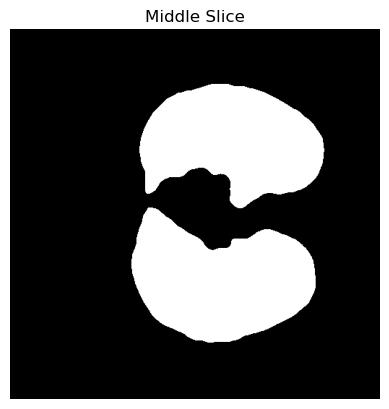

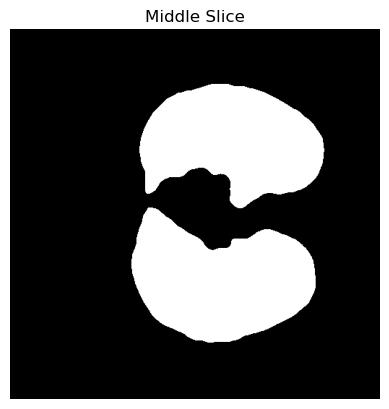

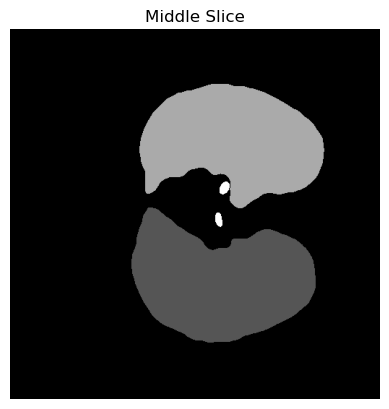

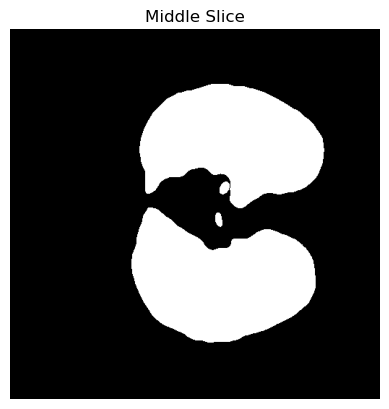

In [50]:
slice_idx = 50
plot_slice(mask_in_left, slice_idx= slice_idx)
plot_slice(mask_in_right, slice_idx= slice_idx)
plot_slice(mask_in_all, slice_idx= slice_idx)
plot_slice(mask_with_trachea, slice_idx= slice_idx)

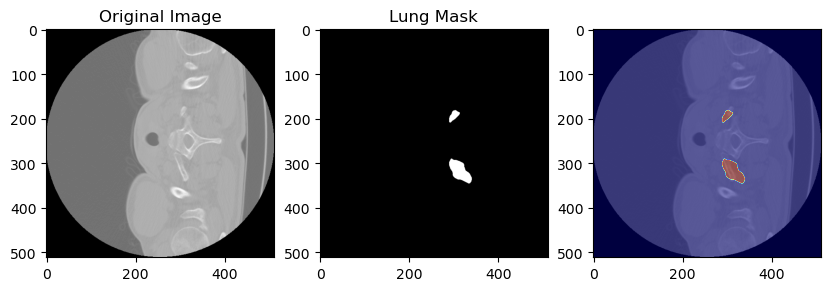

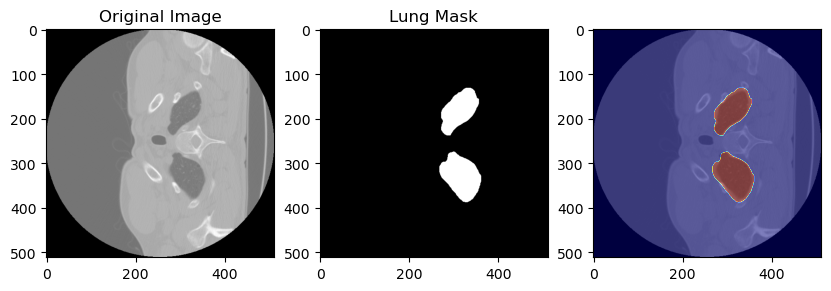

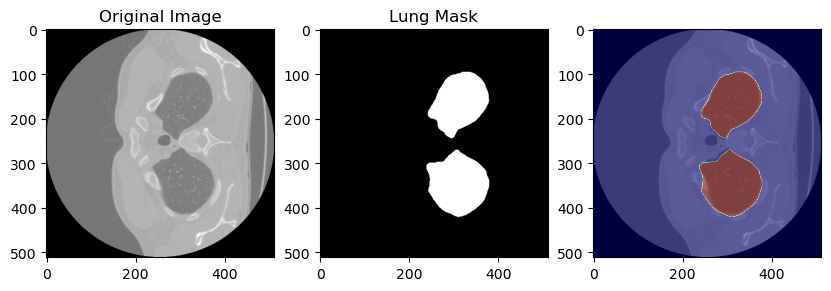

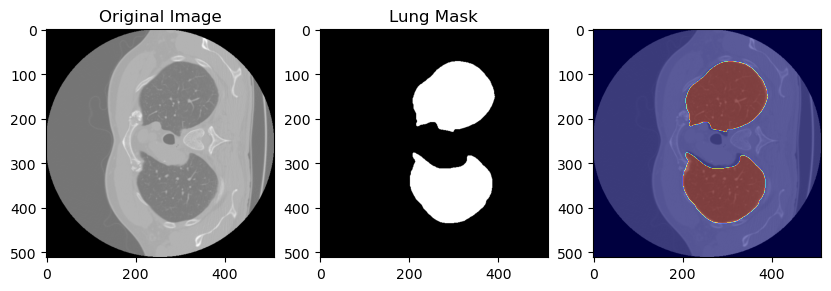

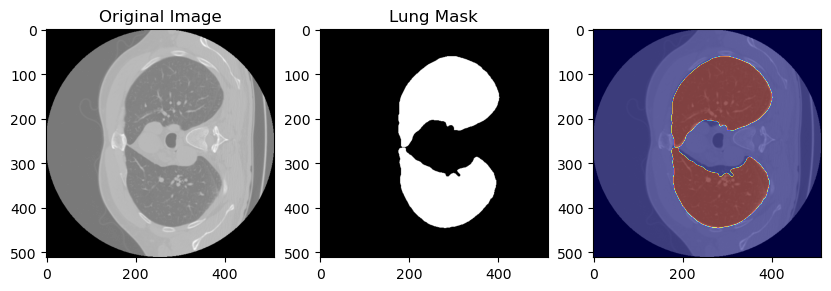

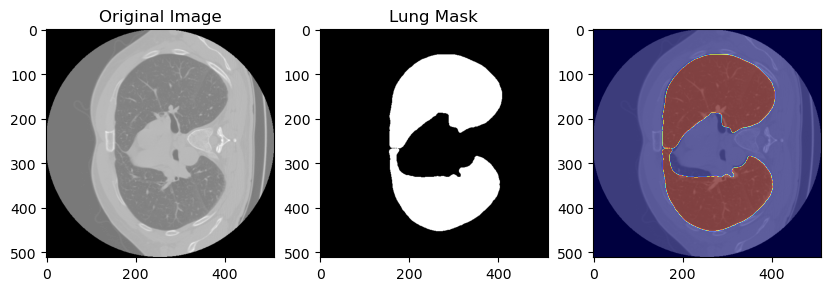

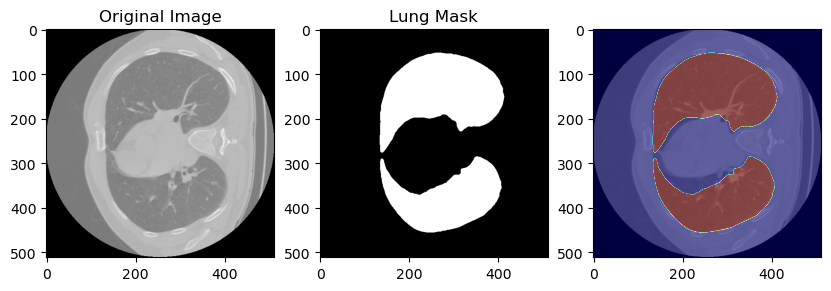

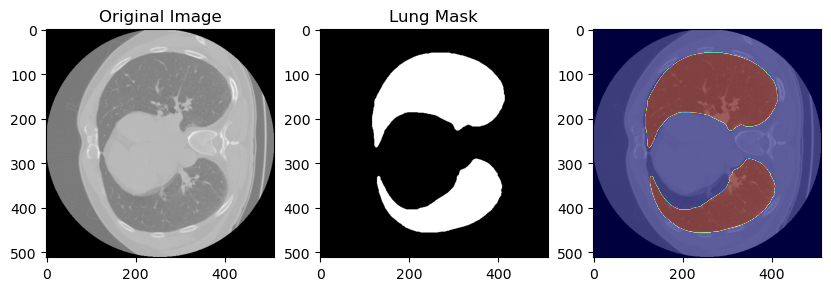

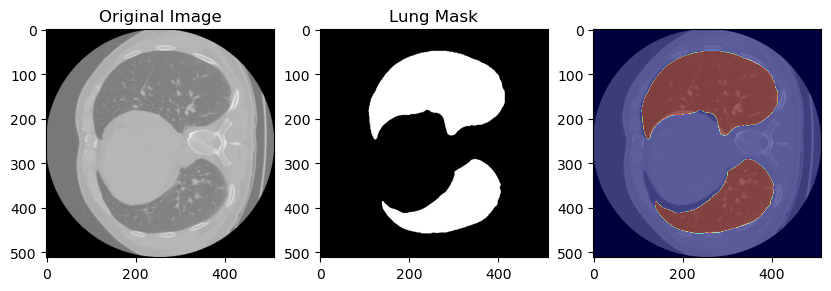

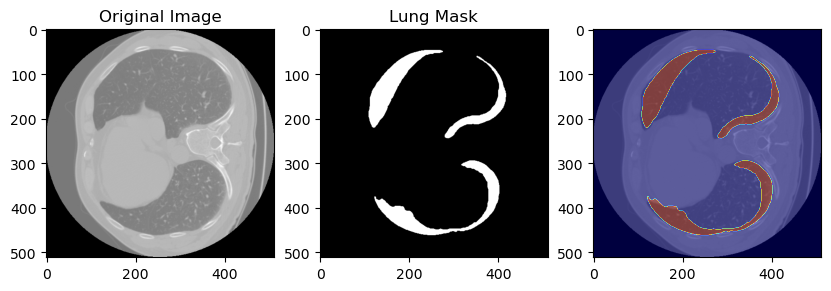

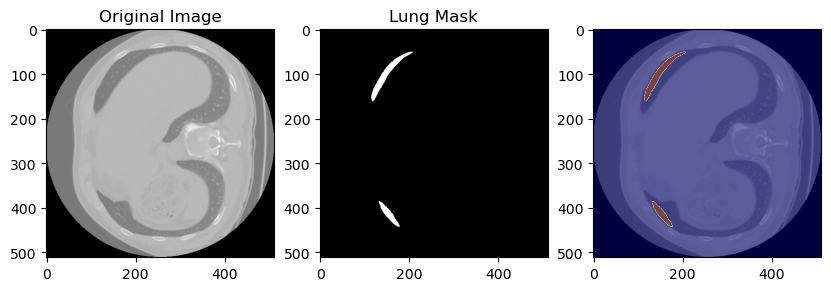

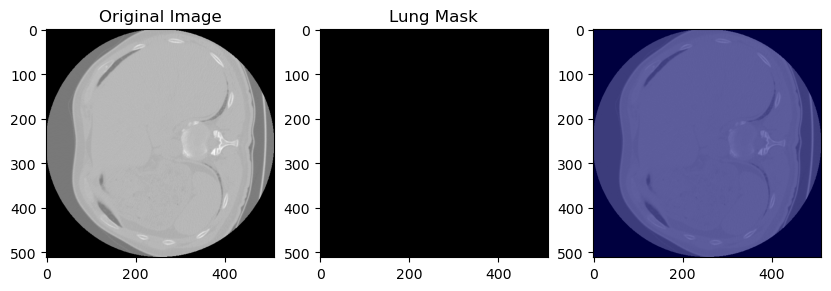

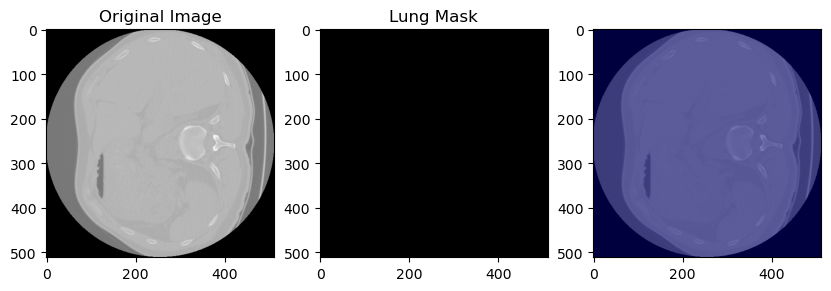

In [131]:
for i in range(0, inhale_data.shape[2], 10):
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        ax[0].imshow(inhale_data[:, :, i], cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(mask_in_trachea[:, :, i], cmap="gray")
        ax[1].set_title("Lung Mask")
        # Overlay the mask on the image
        ax[2].imshow(inhale_data[:, :, i], cmap="gray")
        ax[2].imshow(mask_in_trachea[:, :, i], cmap="jet", alpha=0.5)
        plt.show()

In [4]:

for key, value in dataset_info.items():
    print(f"Processing {key}")
    
    ## Read the images
    inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image_path = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
        
    inhale_image = nib.load(exhale_image_path)
    inhale_data = inhale_image.get_fdata()
    exhale_image = nib.load(exhale_image_path)
    exhale_data = exhale_image.get_fdata()

    ## Preprocess the images
    hu_inhale = hu_data(inhale_data)
    hu_exhale = hu_data(exhale_data)

    inhale_bit_4 = convert_to_signed_4bit(hu_inhale)
    exhale_bit_4 = convert_to_signed_4bit(hu_exhale)

    inhale_bit_4_hu = convert_signed_4bit_to_hu(inhale_bit_4)
    exhale_bit_4_hu = convert_signed_4bit_to_hu(exhale_bit_4)

    lung_inhale = apply_lungmask_binary(inhale_image_path)
    lung_exhale = apply_lungmask_binary(exhale_image_path)

    lung_inhale_threholded = apply_lungmask_thresholded(inhale_data)
    lung_exhale_threholded = apply_lungmask_thresholded(exhale_data)

    lung_inhale_combined = np.bitwise_and(lung_inhale, lung_inhale_threholded)
    lung_exhale_combined = np.bitwise_and(lung_exhale, lung_exhale_threholded)


    ## Export the lung masks
    lung_inhale_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_export_path, exist_ok=True)
    os.makedirs(lung_exhale_export_path, exist_ok=True)
    lung_inhale_nib = nib.Nifti1Image(lung_inhale, inhale_image.affine)
    lung_exhale_nib = nib.Nifti1Image(lung_exhale, exhale_image.affine)
    nib.save(lung_inhale_nib, os.path.join(lung_inhale_export_path, f'{key}_iBHCT_lung_mask.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)
    nib.save(lung_exhale_nib, os.path.join(lung_exhale_export_path, f'{key}_eBHCT_lung_mask.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)

    ## Export the thresholded lung masks
    lung_inhale_thresholded_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_thresholded_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_thresholded_export_path, exist_ok=True)
    os.makedirs(lung_exhale_thresholded_export_path, exist_ok=True)
    lung_inhale_thresholded_nib = nib.Nifti1Image(lung_inhale_threholded, inhale_image.affine)
    lung_exhale_thresholded_nib = nib.Nifti1Image(lung_exhale_threholded, exhale_image.affine)
    nib.save(lung_inhale_thresholded_nib, os.path.join(lung_inhale_thresholded_export_path, f'{key}_iBHCT_lung_mask_thresholded.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)    
    nib.save(lung_exhale_thresholded_nib, os.path.join(lung_exhale_thresholded_export_path, f'{key}_eBHCT_lung_mask_thresholded.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)   

    ## Export the combined lung masks
    lung_inhale_combined_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_combined_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_combined_export_path, exist_ok=True)
    os.makedirs(lung_exhale_combined_export_path, exist_ok=True)
    lung_inhale_combined_nib = nib.Nifti1Image(lung_inhale_combined, inhale_image.affine)
    lung_exhale_combined_nib = nib.Nifti1Image(lung_exhale_combined, exhale_image.affine)
    nib.save(lung_inhale_combined_nib, os.path.join(lung_inhale_combined_export_path, f'{key}_iBHCT_lung_mask_combined.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)
    nib.save(lung_exhale_combined_nib, os.path.join(lung_exhale_combined_export_path, f'{key}_eBHCT_lung_mask_combined.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)


    

Processing copd1
lungmask 2025-01-07 06:26:58 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


 98%|█████████▊| 25/25.6 [00:23<00:00,  1.11it/s]/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 06:27:25 Postprocessing



100%|██████████| 173/173 [00:04<00:00, 40.63it/s]


lungmask 2025-01-07 06:27:34 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:24<00:00,  1.05it/s]

lungmask 2025-01-07 06:28:02 Postprocessing



100%|██████████| 102/102 [00:02<00:00, 40.26it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd2
lungmask 2025-01-07 06:28:21 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:24<00:00,  1.07it/s]

lungmask 2025-01-07 06:28:48 Postprocessing



100%|██████████| 110/110 [00:02<00:00, 50.64it/s]


lungmask 2025-01-07 06:28:53 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 06:29:20 Postprocessing



100%|██████████| 119/119 [00:02<00:00, 50.31it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd3
lungmask 2025-01-07 06:29:36 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 06:30:02 Postprocessing



100%|██████████| 116/116 [00:02<00:00, 42.60it/s]


lungmask 2025-01-07 06:30:09 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:24<00:00,  1.08it/s]

lungmask 2025-01-07 06:30:35 Postprocessing



100%|██████████| 117/117 [00:02<00:00, 41.61it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd4
lungmask 2025-01-07 06:30:54 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:24<00:00,  1.08it/s]

lungmask 2025-01-07 06:31:20 Postprocessing



100%|██████████| 67/67 [00:01<00:00, 40.60it/s] 


lungmask 2025-01-07 06:31:26 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-07 06:31:52 Postprocessing



100%|██████████| 74/74 [00:01<00:00, 55.41it/s] 


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
